<a href="https://colab.research.google.com/github/raheelam98/Chatbot_Agents_Using_LangGraph/blob/main/chatbot_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Customer Support**

LangGraph agents can manage customer inquiries, automate responses, and provide consistent, context-aware support across multiple channels.

In [14]:
# install the required packages

%%capture --no-stderr
%pip install -q -U langgraph langchain_google_genai langchain_core langchain_community tavily-python


In [15]:
# API Keys
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

gemini_api_key = userdata.get('GEMINI_API_KEY')

In [16]:
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

In [4]:
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

In [17]:
# check graph is running
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

In [18]:
#response = llm.invoke([{"role": "user", "content": "greet me"}])
response = llm.invoke("hi")
response

AIMessage(content='Hi! How can I help you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-c76414bc-512d-4f7a-8a48-b822ce730506-0', usage_metadata={'input_tokens': 2, 'output_tokens': 9, 'total_tokens': 11, 'input_token_details': {'cache_read': 0}})

In [83]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage, AIMessage , ToolMessage
from pydantic import BaseModel
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
#from langchain_core.messages import AIMessage, ToolMessage

# STEP 1
# (Part 1 : Basic Chatbot)
# add_messages: Append new messages to the existing list of messages in the state in the graph.
# Define the State class with a list of messages
class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag indicates whether only a human can give instructions
    ask_human: bool   # (Part 6) True means only a human can give instructions


# STEP 2
class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """
    request: str

# STEP 3
tool = TavilySearchResults(max_results=2)
tools = [tool]

# Bind the LLM (Large Language Model) to a tool definition, a pydantic model, or a JSON schema
# Now the LLM is capable of triggering both the Tool and the RequestAssistance Schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])

# STEP 4 :-  default ask_human = False, LLM tells it is flase or true
# Define the chatbot node with modification of ask_human flag
# if response call tool_call then ask_human = true then it routes human route
# Define the chatbot function which uses the bound LLM and tools
def chatbot(state: State):
    # Invoke the LLM with the state messages
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False       # by default ask_human = False
    # Check if the response includes tool calls and if the first tool call is for RequestAssistance
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    # Return the updated state with the response and ask_human flag
    return {"messages": [response], "ask_human": ask_human}

# STEP 5 :- create chatbot and tool node
# Create the graph builder and add the chatbot and tools nodes to the graph, same as before.
graph_builder = StateGraph(State)

# Add the chatbot node to the state graph
graph_builder.add_node("chatbot", chatbot)

# Add the tools node to the state graph with the specified tool
graph_builder.add_node("tools", ToolNode(tools=[tool]))

# STEP 6 :- create human node
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )

# First create helper function for human_node functionality
def human_node(state: State):
    new_messages = []    # Create dictionary
    # Check if the last message from state is from ToolMessage
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to let the LLM continue.
        # If the last message from state is not from ToolMessage
        # then append the generic response, No response from human.
        # Human node triggered but did not get the response.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False, # To protect from infinite loop if no response from human
    }

# Add the human node to the state graph and pass human_node function
graph_builder.add_node("human", human_node)

# STEP 7 :- conditional logic
# When chatbot triggers for human: if ask_human is true, return human
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, route as before
    return tools_condition(state)

graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

# STEP 8 :
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

Visualize the graph

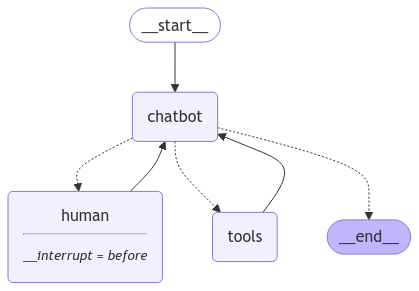

In [84]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

**Gather information**

## Enhancing the Chatbot with Tools

### Chatbot Integrates Web Search Tool

**Chatbot Loop with Real-Time User Input Processing**

In [33]:
# Extracts the latest message from the use
graph = graph_builder.compile()
for event in graph.stream({"messages": [("user", "I am Raheela")]}):
    print("EVENT:", list(event.values())[0]["messages"][-1].content)

# pretty_print()

EVENT: Nice to meet you, Raheela! How can I help you today? 



In [34]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break


User: Karachi weather
Assistant: 
Assistant: [{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Karachi', 'region': 'Sindh', 'country': 'Pakistan', 'lat': 24.8667, 'lon': 67.05, 'tz_id': 'Asia/Karachi', 'localtime_epoch': 1731522303, 'localtime': '2024-11-13 23:25'}, 'current': {'last_updated_epoch': 1731521700, 'last_updated': '2024-11-13 23:15', 'temp_c': 27.4, 'temp_f': 81.3, 'is_day': 0, 'condition': {'text': 'Overcast', 'icon': '//cdn.weatherapi.com/weather/64x64/night/122.png', 'code': 1009}, 'wind_mph': 7.4, 'wind_kph': 11.9, 'wind_degree': 235, 'wind_dir': 'SW', 'pressure_mb': 1013.0, 'pressure_in': 29.91, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 62, 'cloud': 25, 'feelslike_c': 28.9, 'feelslike_f': 84.0, 'windchill_c': 26.1, 'windchill_f': 79.1, 'heatindex_c': 27.4, 'heatindex_f': 81.2, 'dewpoint_c': 17.9, 'dewpoint_f': 64.2, 'vis_km': 5.0, 'vis_miles': 3.0, 'uv': 0.0, 'gust_mph': 11.1, 'gust_kph': 17.9}}"}, {"url": "https://www.wunderground.com/w

### Chatbot Has Memory

**A chatbot can remember the state of the conversation within a given thread ID.**

Now interact with your bot! First, pick a thread to use as the key for this conversation.

In [55]:
config = {"configurable": {"thread_id": "1"}}

In [56]:
user_input = "Hi there! My name is Raheela."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Loop through each event in the stream
for event in events:
    # Print the latest message content from the event
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Raheela.
================================== Ai Message ==================================

Hi Raheela, nice to meet you! 👋 What can I do for you today?


Remember history based on the same thread ID

In [58]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Loop through each event in the stream
for event in events:
    # Print the latest message content from the event
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I will try my best to remember your name, Raheela! 😊  Is there anything else I can help you with?


In [60]:
# Fetch the current state of the graph for the given configuration
#inspect the graph state to confirm it worked.
snapshot = graph.get_state(config)  # Retrieve the current state or status of the graph
print("snapshot ", snapshot)

snapshot  StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Raheela.', additional_kwargs={}, response_metadata={}, id='b29e24a6-5ede-4cfd-975f-ea8c0a0f95c5'), AIMessage(content='Hi Raheela, nice to meet you! 👋 What can I do for you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-aad589bc-2352-4b1c-8f19-a54a4dd5e0e4-0', usage_metadata={'input_tokens': 165, 'output_tokens': 19, 'total_tokens': 184, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Remember my na

In [62]:
snapshot.next   # Retrieve the next node that will execute in the graph

()

In [63]:

existing_message = snapshot.values["messages"][-1]  # Retrieve the most recent message from the snapshot's values
existing_message.pretty_print()   # Print the content of the most recent message

================================== Ai Message ==================================

I will try my best to remember your name, Raheela! 😊  Is there anything else I can help you with?


Notice that unlike last time, the "next" node is set to 'tools'. We've interrupted here! Let's check the tool invocation.

In [64]:
# # `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

I will try my best to remember your name, Raheela! 😊  Is there anything else I can help you with?


The **chatbot can remember the state of the conversation within a given thread** but won't retain context if the thread ID is changed.

In [12]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I am sorry, I do not have memory of past conversations. Is there anything else I can help you with?


#### Human-in-the-loop

**Freezer and un unfreez node**

In [37]:
# User input example
user_input = "I'm learning LangGraph. Could you do some research on it for me?"

# Configuration for the thread ID
config = {"configurable": {"thread_id": "1"}}

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Loop through each event in the stream
for event in events:
    if "messages" in event:
        # Print the latest message content from the event
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (afa517f4-3a51-4d20-b6f4-998a3caaca24)
 Call ID: afa517f4-3a51-4d20-b6f4-998a3caaca24
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and state management."}, {"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a low-level framework that allows you to create stateful, multi-actor app

In [47]:
#inspect the graph state to confirm it worked.
snapshot = graph.get_state(config)  # Retrieve the current state or status of the graph
snapshot

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1'}}, metadata=None, created_at=None, parent_config=None, tasks=())

In [48]:
snapshot.next   # Retrieve the next node that will execute in the graph

()

Notice that unlike last time, the "next" node is set to 'tools'. We've interrupted here! Let's check the tool invocation.

In [66]:
existing_message = snapshot.values["messages"][-1]  # Find out the last message
existing_message.pretty_print()  # Print message

print("\nexisting message - tool_call")
existing_message.tool_calls  # Get tool data

================================== Ai Message ==================================

I will try my best to remember your name, Raheela! 😊  Is there anything else I can help you with?

existing message - tool_call


[]

resume, and check work flow

In [68]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

I will try my best to remember your name, Raheela! 😊  Is there anything else I can help you with?


#### CHECK

Part 5: Manually Updating the State

now write the state

In [74]:
# User input example
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)

# Loop through each event in the stream
for event in events:
    if "messages" in event:
        # Print the latest message content from the event
        event["messages"][-1].pretty_print()

In [75]:
# Fetch the current state of the graph for the given configuration

snapshot = graph.get_state(config)  # Retrieve the current state or status of the graph
print("snapshot ", snapshot)

existing_message = snapshot.values["messages"][-1]  # Retrieve the most recent message from the snapshot's values
existing_message.pretty_print()   # Print the content of the most recent message

snapshot  StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Raheela.', additional_kwargs={}, response_metadata={}, id='b29e24a6-5ede-4cfd-975f-ea8c0a0f95c5'), AIMessage(content='Hi Raheela, nice to meet you! 👋 What can I do for you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-aad589bc-2352-4b1c-8f19-a54a4dd5e0e4-0', usage_metadata={'input_tokens': 165, 'output_tokens': 19, 'total_tokens': 184, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Remember my na

In [76]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (9f570327-b151-477c-bd50-527b5523e2fb)
 Call ID: 9f570327-b151-477c-bd50-527b5523e2fb
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and state management."}, {"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a low-level framework that allows you to create stateful, multi-actor app

#### Part 5: Manually Updating the State